<a href="https://colab.research.google.com/github/Redwolf0023/AutoMLvsBayesian/blob/main/Machine_Maintanence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download all the necessary files for H2O AutoML
!sudo apt-get install swig -y
!pip install Cython numpy
!pip install scikit-learn
!apt-get install default-jre
!java -version
!pip install h2o

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,478 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline


In [ ]:
#Import the necessary documents
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Import Dataset
df = pd.read_csv('predictive_maintenance.csv')

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


0    9661
1     339
Name: Target, dtype: int64


([<matplotlib.patches.Wedge at 0x7d2232a59cc0>,
 [Text(-2.187535298730132, 0.23385747114358105, 'True'),
  Text(2.1875352823086396, -0.23385762475245714, 'False')])

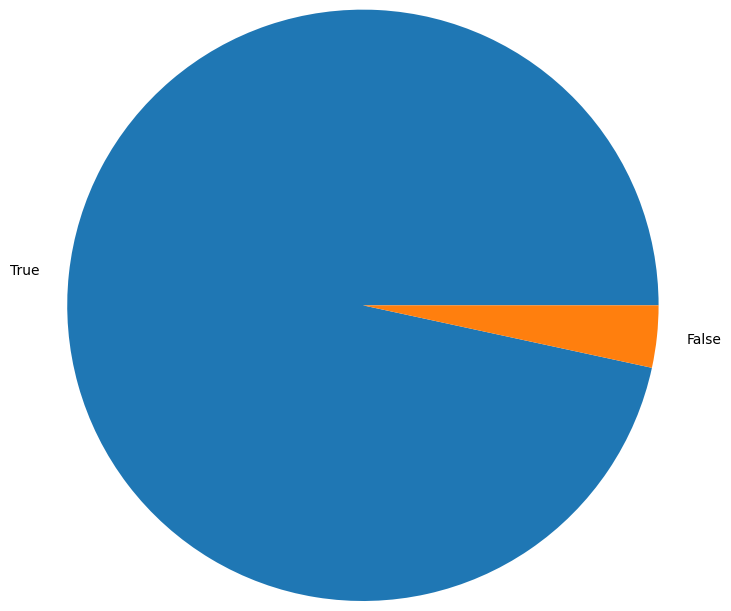

In [ ]:
# Check for the target variable counts
target_counts=df['Target'].value_counts()
labels=['True','False']
print(target_counts)

plt.pie(target_counts,labels=labels,radius=2)

In [ ]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [ ]:
labels2drop=['UDI','Product ID', 'Failure Type']
df=df.drop(columns=labels2drop)

In [ ]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [ ]:
# Initialise H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpez9sam6v
  JVM stdout: /tmp/tmpez9sam6v/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpez9sam6v/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_aw1pby
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Parse the dataset
data = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Select the target and feature column
target_col = data.columns[-1]
feature_col = data.columns[:-1]
data[target_col] = data[target_col].asfactor()

In [ ]:
# create train and test split
train, test, validation = data.split_frame(ratios=[0.8, 0.15], seed = 12)

In [ ]:
# initialise the H2O model keeping 5 as the maximum number of models
model = H2OAutoML(max_models=5, seed = 1234,balance_classes=True)
model.train(x = feature_col, y = target_col, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),2/2
# DRF base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [ ]:
# Inspect the model
exm = model.explain(test)
exm

NameError: ignored

In [ ]:
# Import libraries required for Gaussian process
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, DotProduct, Matern
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score as ras
from sklearn.model_selection import learning_curve

In [ ]:
df=df.drop(columns='Type')
x = df.drop('Target', axis=1).values
y = df['Target'].values

In [ ]:
# Standardize the feature column and label encode the target variable
from sklearn import preprocessing
SS = preprocessing.StandardScaler()
LE = preprocessing.LabelEncoder()
x = SS.fit_transform(x)
y = LE.fit_transform(y)
# Balancing the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the Gaussian Process Classifier using RBF kernel
kernel = 1.0 * RBF()
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)

# Train the Gaussian Process Classifier
gpc.fit(x_train, y_train)

# Make predictions on the test set
predictions = gpc.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision_macro = precision_score(y_test, predictions, average='macro')
recall_macro = recall_score(y_test, predictions, average='macro')
f1_macro = f1_score(y_test, predictions, average='macro')
conf_matrix = confusion_matrix(y_test, predictions)
# Calculate the log-likelihood
y_probs = gpc.predict_proba(x_test)
log_likelihood = log_loss(y_test, y_probs)

In [ ]:
# Calculate ROC curve and AUC for each class (one-vs-all)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision (Macro-average): {precision_macro}")
print(f"Recall (Macro-average): {recall_macro}")
print(f"F1-Score (Macro-average): {f1_macro}")
print(f"Negative Log-Likelihood: {log_likelihood}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')
plt.show()